In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import rasterio
from os.path import exists
from rasterio.features import rasterize
from rasterio.plot import show
from rasterio.enums import Resampling
from matplotlib import pyplot as plt

### Data reading and preprocessing

In [2]:
# Define file path to DOP tiles
filepath = 'D:/COPY/Projekt_FF/Data/'

# Read DOP files as xarray.DataArrays
dop_train = rxr.open_rasterio(filepath + 'dop10rgbi_32_468_5671_1_nw_2021.jp2')
dop_test = rxr.open_rasterio(filepath + 'dop10rgbi_32_466_5670_1_nw_2021.jp2')

# Convert DataArrays to Datasets
dop_train = dop_train.to_dataset(dim='band')
dop_test = dop_test.to_dataset(dim='band')

print(dop_train)
print(dop_test)

<xarray.Dataset>
Dimensions:      (y: 10000, x: 10000)
Coordinates:
  * x            (x) float64 4.68e+05 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y            (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    spatial_ref  int32 0
Data variables:
    1            (y, x) uint8 ...
    2            (y, x) uint8 ...
    3            (y, x) uint8 ...
    4            (y, x) uint8 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
<xarray.Dataset>
Dimensions:      (y: 10000, x: 10000)
Coordinates:
  * x            (x) float64 4.66e+05 4.66e+05 4.66e+05 ... 4.67e+05 4.67e+05
  * y            (y) float64 5.671e+06 5.671e+06 5.671e+06 ... 5.67e+06 5.67e+06
    spatial_ref  int32 0
Data variables:
    1            (y, x) uint8 ...
    2            (y, x) uint8 ...
    3            (y, x) uint8 ...
    4            (y, x) uint8 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


In [3]:
# Convert data type of the spectral band values (uint8) to float32
dop_train = dop_train.astype('float32')
dop_test = dop_test.astype('float32')

In [4]:
# Rename spectral bands
dop_train = dop_train.rename({dop_train[1].name : 'red',
                              dop_train[2].name : 'green',
                              dop_train[3].name : 'blue',
                              dop_train[4].name : 'nir'})

dop_test = dop_test.rename({dop_test[1].name : 'red',
                            dop_test[2].name : 'green',
                            dop_test[3].name : 'blue',
                            dop_test[4].name : 'nir'})

### NDVI calculation
Normalized difference vegetation index (NDVI) is calculated based on it's formula:

$
\begin{align}
NDVI = \frac{NIR - Red}{NIR + Red}
\end{align}
$

where *NIR* are the reflectance values of the near-infrared channel and *red* are the reflectance values of the red channel.

In [5]:
# Calculate normalized difference vegetation index (NDVI)
# for the training DOP and add it to the dataset
ndvi = (dop_train.nir - dop_train.red) / (dop_train.nir + dop_train.red)
dop_train = dop_train.assign({'ndvi' : ndvi})

In [6]:
dop_train

<xarray.Dataset>
Dimensions:      (y: 10000, x: 10000)
Coordinates:
  * x            (x) float64 4.68e+05 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y            (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 105.0 110.0 115.0 115.0 ... 102.0 73.0 38.0
    green        (y, x) float32 112.0 118.0 124.0 125.0 ... 123.0 75.0 45.0
    blue         (y, x) float32 98.0 104.0 110.0 111.0 ... 102.0 105.0 59.0 9.0
    nir          (y, x) float32 147.0 150.0 153.0 156.0 ... 169.0 141.0 106.0
    ndvi         (y, x) float32 0.1667 0.1538 0.1418 ... 0.2472 0.3178 0.4722
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Adding nDOM to the dataset
A normalized digital surface/'oberflächen' model (nDSM/nDOM) is added to the dataset. It's available in 0.5 m resolution. Hence, the DOP (0.1 m resolution) has to be downsampled first.

In [7]:
file_exists = exists(filepath + 'dop_train.tif')

if file_exists != True:
    
    # Save dataset as GeoTIFF
    dop_train.rio.to_raster(filepath + 'dop_train.tif')
    
    # Downsample the DOP to a lower resolution
    # (to that of the nDOM (50cm))
    # DOP shape: (10000, 10000), nDOM shape: (2000, 2000)
    # --> 10000 * 0.2 = 2000
    downscale_factor = 0.2
    
    with rasterio.open(filepath + 'dop_train.tif') as dataset:
        
        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * downscale_factor),
                int(dataset.width * downscale_factor)
            ),
            resampling=Resampling.bilinear
        )
        
        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )    
else:
    
    downscale_factor = 0.2
    
    with rasterio.open(filepath + 'dop_train.tif') as dataset:
        
        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * downscale_factor),
                int(dataset.width * downscale_factor)
            ),
            resampling=Resampling.bilinear
        )
        
        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

In [8]:
# Convert it to xarray DataArray
# and then to Dataset
dop_train_lower_res = xr.DataArray(data, dims=['bands', 'y', 'x'])
dop_train_lower_res = dop_train_lower_res.to_dataset(dim='bands')

# Rename bands again
dop_train_lower_res = dop_train_lower_res.rename({dop_train_lower_res[0].name : 'red',
                                                  dop_train_lower_res[1].name : 'green',
                                                  dop_train_lower_res[2].name : 'blue',
                                                  dop_train_lower_res[3].name : 'nir',
                                                  dop_train_lower_res[4].name : 'ndvi'})

# Assign the nDOM as new data variable
ndom = rxr.open_rasterio(filepath + 'ndom50_32468_5671_1_nw_2021.tif')
dop_train_lower_res = dop_train_lower_res.assign({'ndom' : ndom.squeeze()})

dop_train_lower_res

<xarray.Dataset>
Dimensions:      (y: 2000, x: 2000)
Coordinates:
  * x            (x) float64 4.68e+05 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y            (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    band         int32 1
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 105.1 99.02 106.4 107.8 ... 93.53 99.42 92.54
    green        (y, x) float32 114.2 105.1 112.5 115.8 ... 104.9 110.9 100.0
    blue         (y, x) float32 100.6 87.23 92.48 94.13 ... 88.46 89.77 79.0
    nir          (y, x) float32 149.3 142.3 148.8 152.3 ... 155.4 157.3 148.6
    ndvi         (y, x) float32 0.174 0.1807 0.1673 ... 0.2489 0.2262 0.2388
    ndom         (y, x) float32 ...

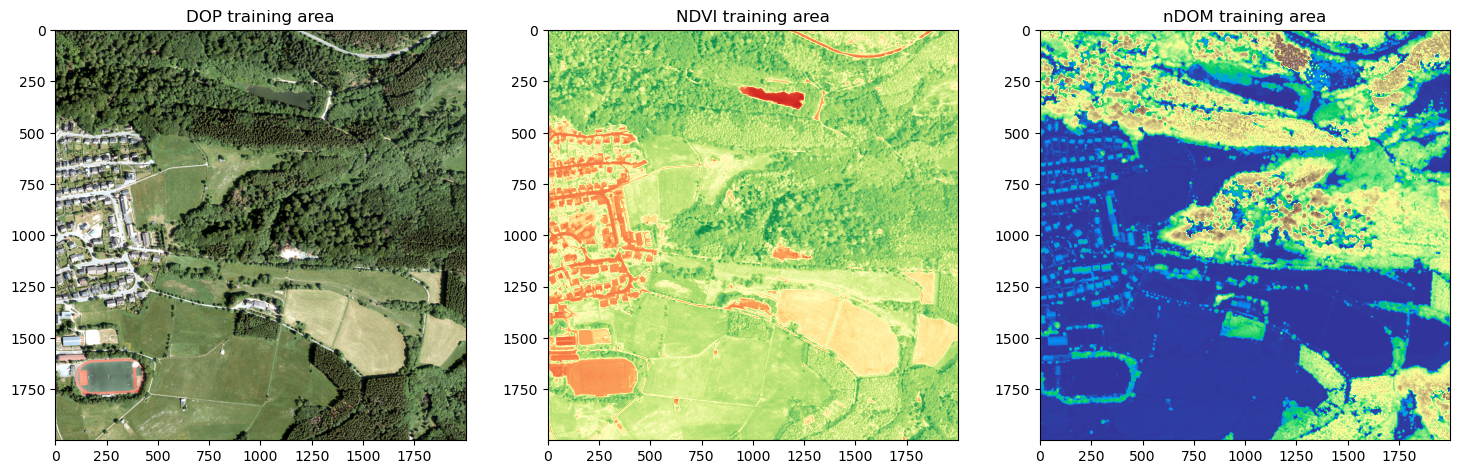

In [9]:
# Helper function to normalize array to range 0-1
# (with clips at lower and upper percentiles (1% - 99%))
def normArray(x):
    lp = 1
    up = 99
    x = np.clip(x, np.nanpercentile(x, lp), np.nanpercentile(x, up))
    x = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
    return x

# Plot the DOP, NDVI, and nDOM for the training area
red   = normArray(dop_train_lower_res.red)
green = normArray(dop_train_lower_res.green)
blue  = normArray(dop_train_lower_res.blue)

fig, ax = plt.subplots(1,3,figsize=(18,12))
ax[0].imshow(np.array([red, green, blue]).transpose(1,2,0))
ax[0].set_title('DOP training area')
ax[1].imshow(np.array([dop_train_lower_res.ndvi]).transpose(1,2,0), cmap='RdYlGn')
ax[1].set_title('NDVI training area')
ax[2].imshow(np.array([dop_train_lower_res.ndom]).transpose(1,2,0), cmap='terrain', vmin=0, vmax=50)
ax[2].set_title('nDOM training area')
plt.show()

### Create raster mask
A raster mask based on the NDVI and the nDOM is created, which can be later used for training. This mask will be filled with values 0 (non-forest), 1 (forest), and NaN, depend on certain values of NDVI and nDOM.

In [10]:
# Add a forest mask to the dataset filled with zeros
dop_train_lower_res['forest_mask']=(['y','x'], [[0] * 2000 for x in range(2000)])
dop_train_lower_res['forest_mask'] = dop_train_lower_res.forest_mask.astype('float32')

In [11]:
dop_train_lower_res

<xarray.Dataset>
Dimensions:      (y: 2000, x: 2000)
Coordinates:
  * x            (x) float64 4.68e+05 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y            (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    band         int32 1
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 105.1 99.02 106.4 107.8 ... 93.53 99.42 92.54
    green        (y, x) float32 114.2 105.1 112.5 115.8 ... 104.9 110.9 100.0
    blue         (y, x) float32 100.6 87.23 92.48 94.13 ... 88.46 89.77 79.0
    nir          (y, x) float32 149.3 142.3 148.8 152.3 ... 155.4 157.3 148.6
    ndvi         (y, x) float32 0.174 0.1807 0.1673 ... 0.2489 0.2262 0.2388
    ndom         (y, x) float32 27.79 27.13 26.75 26.33 ... 23.03 23.1 23.07
    forest_mask  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [12]:
# Fill the forest mask with values 0, 1, and NaN based on NDVI and nDOM values
for (y,x), value in np.ndenumerate(dop_train_lower_res.forest_mask.values):
    
    # NDVI less than 0 and nDOM less than 3 --> non-forest (0)
    if dop_train_lower_res.ndvi.values[y,x] < 0 and dop_train_lower_res.ndom.values[y,x] < 3:
        
        dop_train_lower_res.forest_mask.values[y,x] = 0
    
    # NDVI greater than or equal 0.3 and nDOM greater than or equal 5 --> forest (1)
    elif dop_train_lower_res.ndvi.values[y,x] >= 0.3 and dop_train_lower_res.ndom.values[y,x] >= 5:
        
        dop_train_lower_res.forest_mask.values[y,x] = 1
    
    # all between these:
    # NDVI greater than or equal 0 and less than 0.3, nDOM greater than or equal 3 and less than 5
    # --> NaN (could be forest or non-forest)
    else:
        
        dop_train_lower_res.forest_mask.values[y,x] = np.nan

In [13]:
unique, counts = np.unique(dop_train_lower_res.forest_mask.values, return_counts=True)
dict(zip(unique, counts))

{0.0: 339059, 1.0: 980087, nan: 2680854}

In [14]:
dop_train_lower_res

<xarray.Dataset>
Dimensions:      (y: 2000, x: 2000)
Coordinates:
  * x            (x) float64 4.68e+05 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y            (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    band         int32 1
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 105.1 99.02 106.4 107.8 ... 93.53 99.42 92.54
    green        (y, x) float32 114.2 105.1 112.5 115.8 ... 104.9 110.9 100.0
    blue         (y, x) float32 100.6 87.23 92.48 94.13 ... 88.46 89.77 79.0
    nir          (y, x) float32 149.3 142.3 148.8 152.3 ... 155.4 157.3 148.6
    ndvi         (y, x) float32 0.174 0.1807 0.1673 ... 0.2489 0.2262 0.2388
    ndom         (y, x) float32 27.79 27.13 26.75 26.33 ... 23.03 23.1 23.07
    forest_mask  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

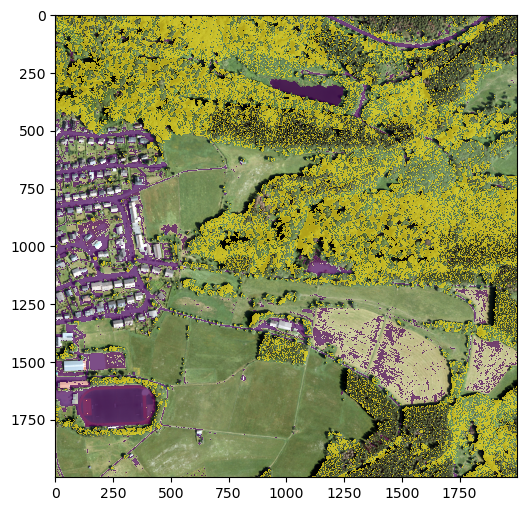

In [15]:
# Plot DOP (training area) with the created forest mask (NaN values not shown)
# yellow = forest
# purple = non-forest
# NaN (not coloured) = could be forest or non-forest
plt.figure(figsize=(10,6))
plt.imshow(np.array([red, green, blue]).transpose(1,2,0))
plt.imshow(dop_train_lower_res.forest_mask.values, interpolation='None', alpha=0.7)
plt.show()

In [16]:
# Write to disk
dop_train_lower_res.to_netcdf('D:/COPY/Projekt_FF/Process/dop_train_lower_res_forestmask.nc', mode='w')